In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [6]:
def create_advanced_features(transactions_df, customers_df):
    """Create more sophisticated features from transaction data"""
    # Merge datasets
    customer_transactions = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')
    
    # Convert TransactionDate to datetime
    customer_transactions['TransactionDate'] = pd.to_datetime(customer_transactions['TransactionDate'])
    
    # Advanced feature engineering
    customer_features = customer_transactions.groupby('CustomerID').agg(
        total_spent=('TotalValue', 'sum'),
        avg_spent=('TotalValue', 'mean'),
        total_quantity=('Quantity', 'sum'),
        transaction_count=('TransactionID', 'count'),
        avg_quantity_per_transaction=('Quantity', lambda x: x.mean()),
        spending_frequency=('TransactionDate', lambda x: (x.max() - x.min()).days),
        avg_transaction_value=('TotalValue', 'mean'),
        total_transactions=('TransactionID', 'nunique'),
        region=('Region', 'first')
    ).reset_index()
    
    # Calculate derived metrics
    customer_features['avg_spend_per_day'] = (customer_features['total_spent'] / 
                                              customer_features['spending_frequency'].replace(0, 1))
    customer_features['quantity_per_spend'] = (customer_features['total_quantity'] / 
                                               customer_features['total_spent'])
    
    return customer_features

In [3]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [7]:
customer_features = create_advanced_features(transactions_df, customers_df)

In [8]:
encoder = OneHotEncoder(sparse=False)
region_encoded = encoder.fit_transform(customer_features[['region']])
region_encoded_df = pd.DataFrame(region_encoded, 
                                 columns=encoder.get_feature_names_out(['region']))


C:\Vinit\PROGRAMMING LANGUAGE\PYTHON (Udemy)\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
features_for_clustering = ['total_spent', 'total_quantity', 'avg_quantity_per_transaction', 'avg_transaction_value','avg_spend_per_day', 'quantity_per_spend']

In [10]:
final_features = pd.concat([
    customer_features[features_for_clustering].reset_index(drop=True),
    region_encoded_df
], axis=1)

In [11]:
scaler = RobustScaler()
scaled_features = scaler.fit_transform(final_features)

In [12]:
max_clusters = min(11, len(customer_features) // 30)  # Ensure reasonable number of clusters
clusters_range = range(2, max_clusters)

In [13]:
db_index_scores = []
silhouette_scores = []
inertia_scores = []

In [14]:
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    silhouette = silhouette_score(scaled_features, cluster_labels)
    inertia = kmeans.inertia_
    
    db_index_scores.append(db_index)
    silhouette_scores.append(silhouette)
    inertia_scores.append(inertia)

C:\Vinit\PROGRAMMING LANGUAGE\PYTHON (Udemy)\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Vinit\PROGRAMMING LANGUAGE\PYTHON (Udemy)\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Vinit\PROGRAMMING LANGUAGE\PYTHON (Udemy)\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Vinit\PROGRAMMING LANGUAGE\PYTHON (Udemy)\lib\site-packages\sklearn\clust

In [15]:
normalized_db = (db_index_scores - np.min(db_index_scores)) / (np.max(db_index_scores) - np.min(db_index_scores))

In [16]:
normalized_silhouette = 1 - ((silhouette_scores - np.min(silhouette_scores)) / (np.max(silhouette_scores) - np.min(silhouette_scores)))

In [17]:
normalized_inertia = (inertia_scores - np.min(inertia_scores)) / (np.max(inertia_scores) - np.min(inertia_scores))

In [18]:
combined_scores = normalized_db + normalized_silhouette + normalized_inertia

In [19]:
optimal_clusters = clusters_range[np.argmin(combined_scores)]

In [20]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)

In [21]:
final_labels = kmeans.fit_predict(scaled_features)

C:\Vinit\PROGRAMMING LANGUAGE\PYTHON (Udemy)\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [24]:
customer_features['Cluster'] = final_labels

In [25]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

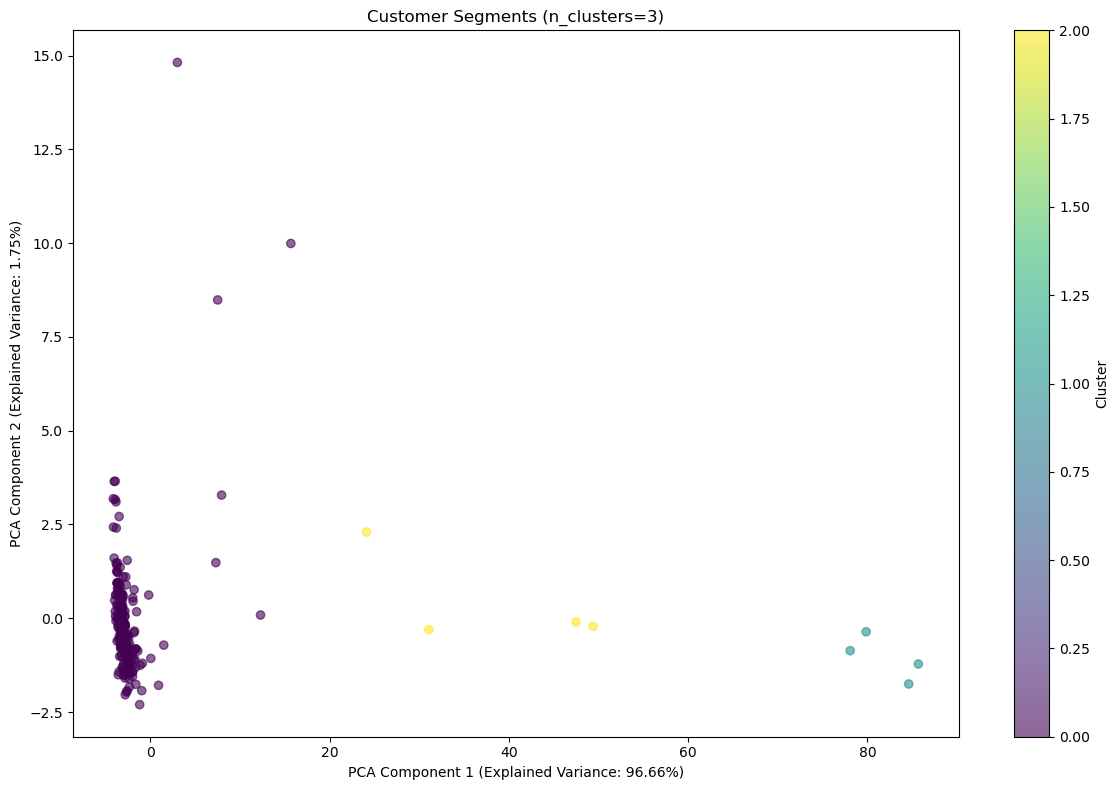

In [26]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                       c=final_labels, cmap='viridis', alpha=0.6)
plt.title(f'Customer Segments (n_clusters={optimal_clusters})')
plt.xlabel(f'PCA Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PCA Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

In [27]:
customer_features.to_csv('Customer_Clusters.csv', index=False)

In [28]:
final_report = {
    "Optimal Clusters": optimal_clusters,
    "DB Index": db_index_scores[optimal_clusters-2],
    "Silhouette Score": silhouette_scores[optimal_clusters-2],
}

print("\nClustering Report:", final_report)


Clustering Report: {'Optimal Clusters': 3, 'DB Index': 0.31953409394939275, 'Silhouette Score': 0.898410213853043}
